# EzyRB Tutorial 3

## Tutorial for Neural Network shift-based pre-processed POD

In this tutorial we will explain how to use the **Neural Network shifted-proper orthogonal decomposition** algorithm implemented in **EZyRB** library.

NNsPOD algorithm is purely a data-driven machine learning method that seeks for an optimal mapping of the various snapshots in the low-rank linear subspace to a reference configuration via an automatic detection and aims at building a pre-processing transformation that accelerates the Kolmogorov R−width decay for advection-dominated problems.

Reference: Papapicco, D., Demo, N., Girfoglio, M., Stabile, G., & Rozza, G.(2022). The Neural Network shifted-proper orthogonal decomposition: A machine learning approach for non-linear reduction of hyperbolic equations.Computer Methods in Applied Mechanics and Engineering, 392, 114687 - https://doi.org/10.1016/j.cma.2022.114687

### Problem defintion 

We consider **1D gaussion distribution functions**, in wihch $x$ is random variable, $ \mu $ is mean and $ \sigma^2 $ is variance, where $ \sigma $ is the standard deviation or the width of gaussian.
$$
f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-(x-\mu)^2 /\left(2 \sigma^2\right)}
$$

Here we parameterize the mean $\mu$ values, where changing $\mu$ shifts the distribution along x-axis. 

### Initial setting

First of all import the required packages: We need the standard Numpy, Torch, Matplotlib, and some classes from EZyRB.

* `numpy:` to handle arrays and matrices we will be working with.
* `torch:` to enable the usage of Neural Networks
* `matplotlib:` to handle the plotting environment. 

From `EZyRB` we need:
1. The `ROM` class, which performs the model order reduction process.
2. A module such as `Database`, where the matrices of snapshots and parameters are stored. 
3. A dimensionality reduction method such as Proper Orthogonal Decomposition `POD`
4. An interpolation method to obtain an approximation for the parametric solution for a new set of parameters such as the Radial Basis Function `RBF`, or Multidimensional Linear Interpolator `Linear`.

In [1]:
import numpy as np
import torch
from scipy import spatial
from matplotlib import pyplot as plt

from ezyrb import POD, RBF, Database, Snapshot, Parameter, Linear, ANN
from ezyrb import ReducedOrderModel as ROM
from ezyrb.plugin import AutomaticShiftSnapshots

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def wave(t, res=256):   
    x = np.linspace(0, 10, res)
    return x, gaussian(x, t, 0.1)   # parameterizing mean value

## Offline phase 

In this case, we obtain 15 snapshots from the analytical model. 

In [3]:
n_params = 15
params = np.linspace(0.5, 4.5, n_params).reshape(-1, 1)
print(params.shape)

(15, 1)


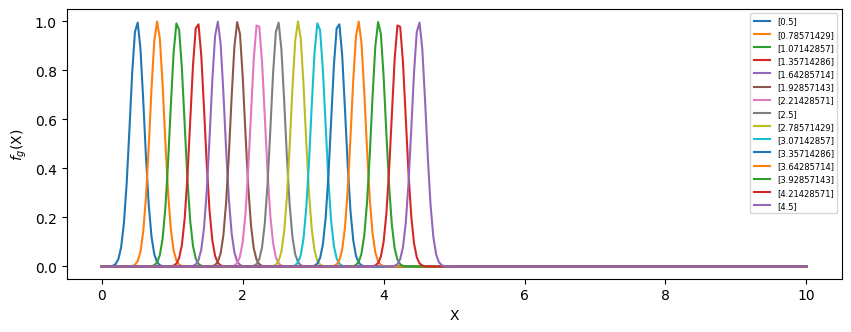

In [4]:
pod = POD() #rank=1 
rbf = RBF()
db = Database()
for param in params:
    space, values = wave(param)
    snap = Snapshot(values=values, space=space)
    db.add(Parameter(param), snap)
    plt.rcParams["figure.figsize"] = (10,3.5)
    plt.plot(Snapshot(space), Snapshot(values), label = param)
    plt.ylabel('$f_{g}$(X)') 
    plt.xlabel('X')
    plt.legend(prop={'size': 6})

In [5]:
snap = db.snapshots_matrix
pa = db.parameters_matrix
print(snap.shape, pa.shape)

(15, 256) (15, 1)


In [6]:
db_train, db_test = db.split([len(db)-3, 3])
print("lenght of training data set :", len(db_train))
print("lenght of test data set :", len(db_test))

lenght of training data set : 12
lenght of test data set : 3


`InterpNet:` must learn the reference configuration in the best possible way w.r.t its grid point distribution such that it will be able to reconstruct its "shape" for every shifted centroid disrtribution.  

`ShiftNet:` To quantify the optimal-shift for the pre-processing transformation of the full-order manifold and that maximizes the kolmogrov width decay.  

`Training:` The training of ShiftNet and InterpNet are seperated with the latter being trained first. Once the network has learned the best-possible reconstruct of the solution field of the reference configuration, its forward map will be used for the training of Shiftnet as well, in a cascaded fashion. For this reason, we  must optimise the loss of interpnet considerably  more than ShiftNet's. 

In [10]:
interp = ANN([10, 10], torch.nn.Softplus(), 1000, frequency_print=200, lr=0.03)
shift  = ANN([], torch.nn.LeakyReLU(), [1e-3, 4000], optimizer=torch.optim.Adam, frequency_print=200, l2_regularization=0,  lr=0.0023)
nnspod = AutomaticShiftSnapshots(shift, interp, Linear(fill_value=0.0), parameter_index=2, reference_index=2, barycenter_loss=20.)
rom = ROM(db_train, pod, rbf, plugins=[nnspod])

In [11]:
for _ in range(10):
    rom.fit()    # Calculate reduced space
    if rom.plugins[0].shift_network.loss_trend[-1] < 1e-3:
        break

[epoch      1]	5.011598e-02
[epoch    200]	1.508386e-02
[epoch    400]	1.875880e-03
[epoch    600]	2.014568e-04
[epoch    800]	7.686181e-05
[epoch   1000]	4.150243e-05
[epoch      1]	5.322180e-01
[epoch    200]	1.771568e-01
[epoch    400]	1.531563e-02
[epoch    600]	5.819951e-03
[epoch    800]	2.543963e-03
[epoch   1000]	1.346418e-03
[epoch   1140]	9.995232e-04


(12, 256)


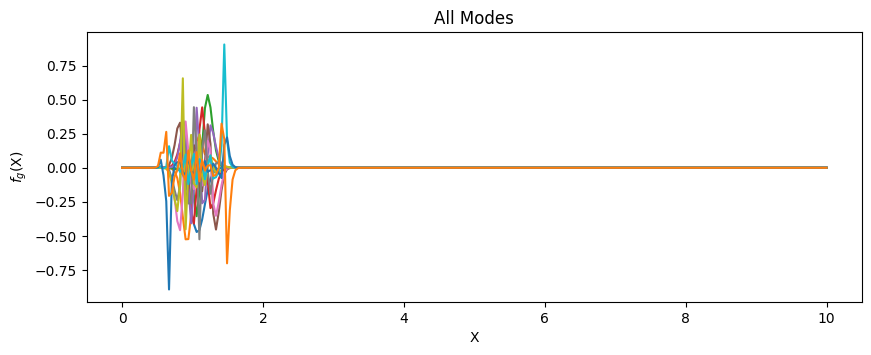

"\n# For each mode\nfor i in range(0, len(db_train)):\n    plt.plot(space, m[i, :]*-1, label = i+1 )\n    plt.legend()\n    plt.title('Mode = {0}'.format(i+1))\n    plt.show()\n"

In [12]:
modes = pod.modes
m = modes.transpose()
print(m.shape)
plt.plot(space, pod.modes)
plt.title('All Modes')
plt.ylabel('$f_{g}$(X)') 
plt.xlabel('X')
plt.show()

"""
# To plot each mode
for i in range(0, len(db_train)):
    plt.plot(space, m[i, :]*-1, label = i+1 )
    plt.legend()
    plt.title('Mode = {0}'.format(i+1))
    plt.show()
"""

## Online phase 

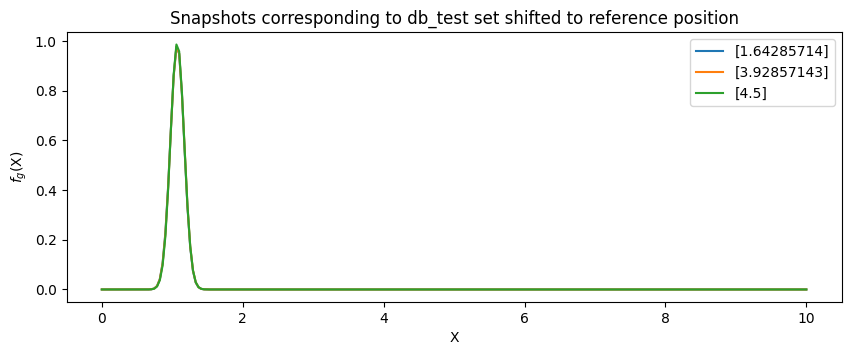

In [13]:
pred = rom.predict(db_test.parameters_matrix) # Calculate predicted solution for given mu

for i in range(len(pred)):
    plt.plot(space, pred.snapshots_matrix[i], label = pred.parameters_matrix[i])
    plt.legend()
    plt.ylabel('$f_{g}$(X)') 
    plt.xlabel('X')
    plt.title('Snapshots corresponding to db_test set shifted to reference position')

In [14]:
error = 0.0

for (_, snap), (_, truth_snap) in zip(pred._pairs, db_test._pairs):
    tree = spatial.KDTree(truth_snap.space.reshape(-1, 1))
    for coord, value in zip(snap.space, snap.values):
        a = tree.query(coord)
        error += np.abs(value - truth_snap.values[a[1]])

assert error < 25

print(error)

9.41921904056389


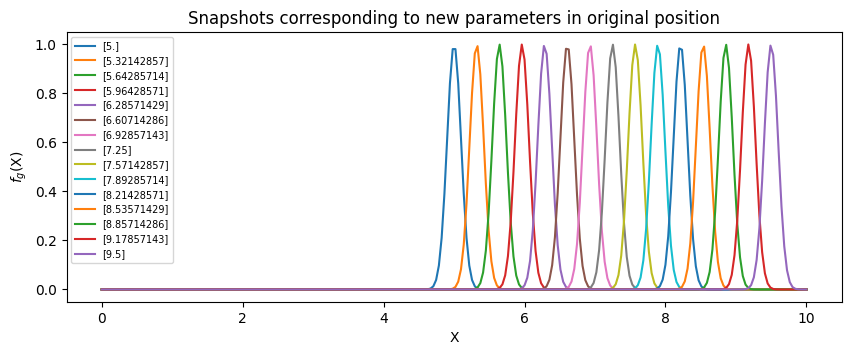

In [15]:
new_params = np.linspace(5, 9.5, n_params).reshape(-1, 1)
pred_new = rom.predict(new_params)

for param in new_params:
    x, y = wave(param)
    plt.rcParams["figure.figsize"] = (10,3.5)
    plt.plot(x,y, label = param)
    plt.legend(prop={'size': 7})
    plt.ylabel('$f_{g}$(X)') 
    plt.xlabel('X')
    plt.title('Snapshots corresponding to new parameters in original position')

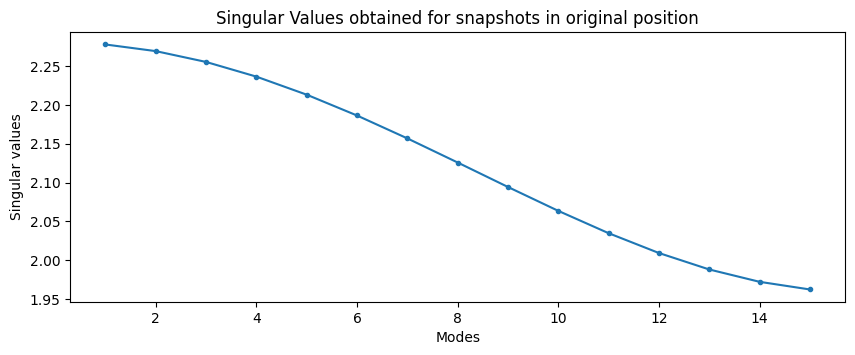

In [16]:
# prior to shift 
x, y = wave(new_params)
U, s = np.linalg.svd(y, full_matrices=False)[:2]
N_modes = np.linspace(1, len(new_params),len(new_params))
plt.plot(N_modes, s, ".-")
plt.ylabel('Singular values')
plt.xlabel('Modes')
plt.title('Singular Values obtained for snapshots in original position')
plt.show()

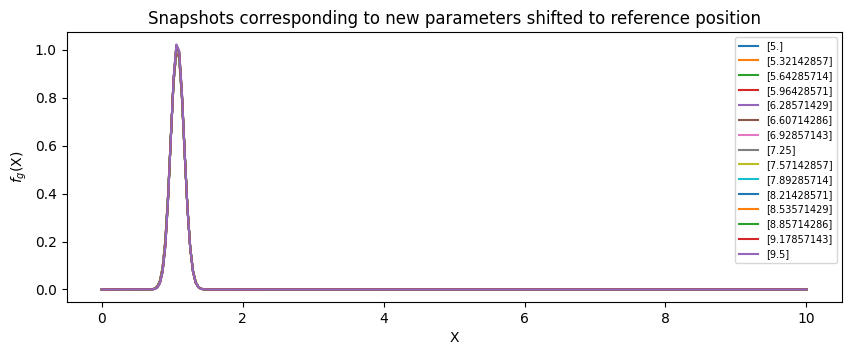

In [17]:
pred_new = rom.predict(new_params)
p = pred_new.parameters_matrix
l = pred_new.snapshots_matrix
#print(p.shape, l.shape)
for i in range(len(pred_new)):
    plt.rcParams["figure.figsize"] = (10,3.5)
    plt.plot(space, pred_new.snapshots_matrix[i], label = pred_new.parameters_matrix[i])
    plt.legend(prop={'size': 7})
    plt.ylabel('$f_{g}$(X)') 
    plt.xlabel('X')
    plt.title('Snapshots corresponding to new parameters shifted to reference position')

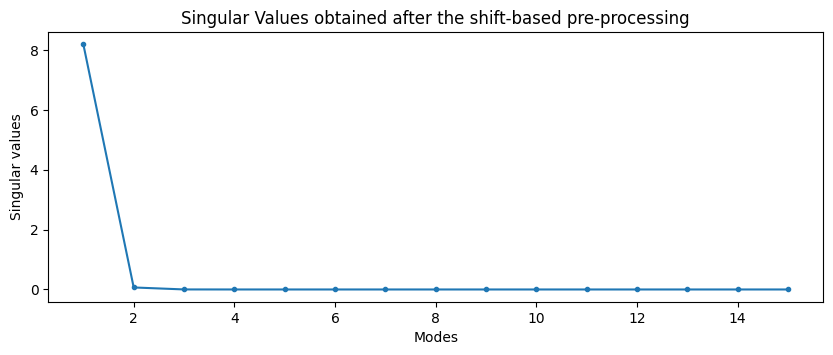

In [18]:
# After the shift-based pre-processing
U_new, s_new = np.linalg.svd(pred_new.snapshots_matrix, full_matrices=False)[:2]

N_modes = np.linspace(1, len(new_params),len(new_params))

plt.plot(N_modes, s_new, ".-")
plt.ylabel('Singular values')
plt.xlabel('Modes')
plt.title('Singular Values obtained after the shift-based pre-processing')
plt.show()